In [ ]:
import time

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/APS360/Tutorials

/content/drive/MyDrive/Colab Notebooks/APS360/Tutorials


In [ ]:
# Load data
X_train = pd.read_csv("train.csv") #load data from csv

y_train = X_train["Survived"]
X_train.drop(labels="Survived", axis=1, inplace=True) #ground truth from train_data

drop_columns = ["Name", "Age", "SibSp", "Ticket", "Cabin", "Parch", "Embarked"] # drop unimportant columns
X_train.drop(labels=drop_columns, axis=1, inplace=True)

X_train = pd.get_dummies(X_train, columns=["Sex"])
X_train.fillna(value=0.0, inplace=True) #fill empty cells with 0

# split data 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                            test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                            test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

print("X_train:", len(X_train))
print("y_train:", len(y_train))
print("X_val:", len(X_val))
print("y_val:", len(y_val))
print("X_test:", len(X_test))
print("y_test:", len(y_test))

X_train: 534
y_train: 534
X_val: 178
y_val: 178
X_test: 179
y_test: 179


In [ ]:
# Hyperparameters (96 combinations)
n_estimators = [1, 10, 20, 50, 100, 200] # 6 parameters
lr = [0.001, 0.01, 0.5, 1]     # 4 parameters
max_depth = [1, 2, 5, 10]           # 4 parameters

In [ ]:
def tune_parameters(n_estimators, lr, max_depth):
    model_num = 0
    cur_train_acc = 0
    cur_val_acc = 0
    parameters = np.zeros(3)
    for estimator in n_estimators:
        for learn_rate in lr:
            for depth in max_depth:
                model_num += 1
                train_acc, val_acc, model = baseline(estimator, learn_rate, depth, model_num)

                if (train_acc > cur_train_acc) & (val_acc > cur_val_acc):
                    cur_train_acc = train_acc
                    cur_val_acc = val_acc
                    parameters[0] = estimator
                    parameters[1] = learn_rate
                    parameters[2] = depth
                    
    print("Optimized parameters [n_estimators, learning_rate, max_depth]", parameters)
    print("Optimized training accuracy:", cur_train_acc)
    print("Optimized validation accuracy:", cur_val_acc)
    return cur_train_acc, cur_val_acc, parameters

In [ ]:
def baseline(n_estimators, lr, max_depth, model_num):
    # Gradient boosted trees
    baseline_model = GradientBoostingClassifier(n_estimators=n_estimators, 
                                learning_rate=lr, max_depth=max_depth, random_state=1)

    # Fit the model to our training data
    start_time = time.time()
    classifier = baseline_model.fit(X_train, y_train)
    end_time = time.time()

    # Accuracy
    train_acc = baseline_model.score(X_train, y_train)
    val_acc = baseline_model.score(X_val, y_val)

    print("Model #", model_num)
    print("number of estimators: %s, learning rate: %s, max_depth: %s" 
                % (n_estimators, lr, max_depth))
    print("Training accuracy: {0:.3f}".format(train_acc))
    print("Validation accuracy: {0:.3f}".format(val_acc))
    print("Total time: {0:.3f} seconds".format(end_time - start_time))

    return train_acc, val_acc, baseline_model

In [ ]:
# Final test accuracy
def get_test_accuracy(model, X_test, y_test):
    '''
    Returns accuracy on test set.
    '''
    # Make predictions - test accuracy
    test_pred = model.predict(X_test)
    score = accuracy_score(test_pred, y_test)
    print("Test Accuracy:", score)

    # Confusion matrix
    class_names = ["Survived", "Not survived"]
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, test_pred))

    disp = plot_confusion_matrix(model, X_test, y_test,
                                    display_labels=class_names,
                                    cmap=plt.cm.Blues,
                                    normalize='true')
    disp.ax_.set_title("Confusion Matrix (Normalized)")

    print("Confusion Matrix (Normalized)")
    print(disp.confusion_matrix)

    plt.show()

Model # 1
number of estimators: 1, learning rate: 0.001, max_depth: 1
Training accuracy: 0.612
Validation accuracy: 0.652
Total time: 0.007 seconds
Model # 2
number of estimators: 1, learning rate: 0.001, max_depth: 2
Training accuracy: 0.612
Validation accuracy: 0.652
Total time: 0.002 seconds
Model # 3
number of estimators: 1, learning rate: 0.001, max_depth: 5
Training accuracy: 0.612
Validation accuracy: 0.652
Total time: 0.003 seconds
Model # 4
number of estimators: 1, learning rate: 0.001, max_depth: 10
Training accuracy: 0.612
Validation accuracy: 0.652
Total time: 0.007 seconds
Model # 5
number of estimators: 1, learning rate: 0.01, max_depth: 1
Training accuracy: 0.612
Validation accuracy: 0.652
Total time: 0.006 seconds
Model # 6
number of estimators: 1, learning rate: 0.01, max_depth: 2
Training accuracy: 0.612
Validation accuracy: 0.652
Total time: 0.005 seconds
Model # 7
number of estimators: 1, learning rate: 0.01, max_depth: 5
Training accuracy: 0.612
Validation accuracy

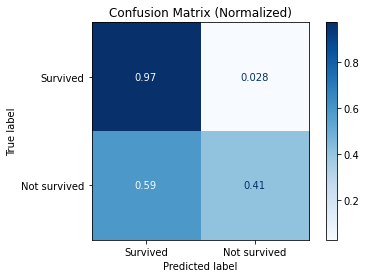

In [ ]:
# Main code to run
best_train_acc, best_val_acc, parameters = tune_parameters(n_estimators, lr, max_depth) # tune to get best parameters
# load best model
best_model = GradientBoostingClassifier(n_estimators=int(parameters[0]), 
                                learning_rate=parameters[1], max_depth=int(parameters[2]), random_state=1)
classifier = best_model.fit(X_train, y_train)
# get test accuracy
get_test_accuracy(best_model, X_test, y_test)